In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as stats
import pylab as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso        # regularizacion L1
from sklearn.linear_model import Ridge        # regularizacion L2
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.tree import ExtraTreeRegressor as ETR
#%pip install xgboost
#%pip install catboost
#%pip install lightgbm
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
from catboost import CatBoostRegressor as CTR

In [2]:
salaries_ori = pd.read_csv('data/salaries_data.csv')
sal = salaries_ori.copy()

In [3]:
testeo_ori = pd.read_csv('data/testeo.csv')
test = testeo_ori.copy()
test.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2020,SE,FT,Machine Learning Scientist,260000,USD,JP,0,JP,S
1,2020,MI,FT,Lead Data Analyst,87000,USD,US,100,US,L
2,2020,MI,FT,Data Analyst,85000,USD,US,100,US,L
3,2020,MI,FT,Machine Learning Engineer,299000,CNY,CN,0,CN,M
4,2020,MI,FT,Product Data Analyst,450000,INR,IN,100,IN,L


Lo primero navegamos por la bbdd y vemos qué datos hay.
- Revisamos si hay nulos (no hay)
- Revisamos si hay que modificar algunos type (están bien etiquetados)
- Revisamos si hay gran cantidad de datos duplicados


In [4]:
sal.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Engineer,140250,USD,140250,US,100,US,M
1,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
2,2021,MI,FT,BI Data Analyst,100000,USD,100000,US,100,US,M
3,2021,MI,CT,ML Engineer,270000,USD,270000,US,100,US,L
4,2021,MI,FT,Data Engineer,22000,EUR,26005,RO,0,US,L


In [5]:
sal.shape

(500, 11)

In [6]:
sal.employment_type.value_counts()

FT    484
PT      8
CT      4
FL      4
Name: employment_type, dtype: int64

In [7]:
sal.loc[sal['employment_type'] == 'FL']

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
21,2021,MI,FL,Machine Learning Scientist,12000,USD,12000,PK,50,PK,M
46,2021,MI,FL,Data Engineer,20000,USD,20000,IT,0,US,L
176,2020,SE,FL,Computer Vision Engineer,60000,USD,60000,RU,100,US,S
326,2022,MI,FL,Data Scientist,100000,USD,100000,CA,100,US,M


In [8]:
sal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           500 non-null    int64 
 1   experience_level    500 non-null    object
 2   employment_type     500 non-null    object
 3   job_title           500 non-null    object
 4   salary              500 non-null    int64 
 5   salary_currency     500 non-null    object
 6   salary_in_usd       500 non-null    int64 
 7   employee_residence  500 non-null    object
 8   remote_ratio        500 non-null    int64 
 9   company_location    500 non-null    object
 10  company_size        500 non-null    object
dtypes: int64(4), object(7)
memory usage: 43.1+ KB


In [9]:
sal.duplicated().sum()

34

Decidimos no eliminar los duplicados ya que no hay una gran cantidad y para entrenar los modelos predictivos, es interesante contar con la mayor cantidad de datos posible.

Una vez revisada la bbdd, vamos a analizar las columnas.
- la importancia de las columnas en la explicación de salary

In [10]:
sal['experience_level'] =LabelEncoder().fit_transform(sal.experience_level)
test['experience_level'] =LabelEncoder().fit_transform(test.experience_level)

In [11]:
sal['employment_type'] =LabelEncoder().fit_transform(sal.employment_type)
test['employment_type'] =LabelEncoder().fit_transform(test.employment_type)

In [12]:
sal['salary_currency'] =LabelEncoder().fit_transform(sal.salary_currency)
test['salary_currency'] =LabelEncoder().fit_transform(test.salary_currency)

In [13]:
sal['employee_residence'] =LabelEncoder().fit_transform(sal.employee_residence)
test['employee_residence'] =LabelEncoder().fit_transform(test.employee_residence)

In [14]:
sal['company_location'] =LabelEncoder().fit_transform(sal.company_location)
test['company_location'] =LabelEncoder().fit_transform(test.company_location)

In [15]:
sal['company_size'] =LabelEncoder().fit_transform(sal.company_size)
test['company_size'] =LabelEncoder().fit_transform(test.company_size)

In [16]:
sal['job_title'] = LabelEncoder().fit_transform(sal.job_title)
test['job_title'] = LabelEncoder().fit_transform(test.job_title)

In [17]:
sal.shape

(500, 11)

In [18]:
sal.salary_in_usd.describe()

count       500.000000
mean     112996.216000
std       69613.750601
min        2859.000000
25%       64594.500000
50%      103080.000000
75%      150000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

In [19]:
sal.salary_in_usd.median()

103080.0

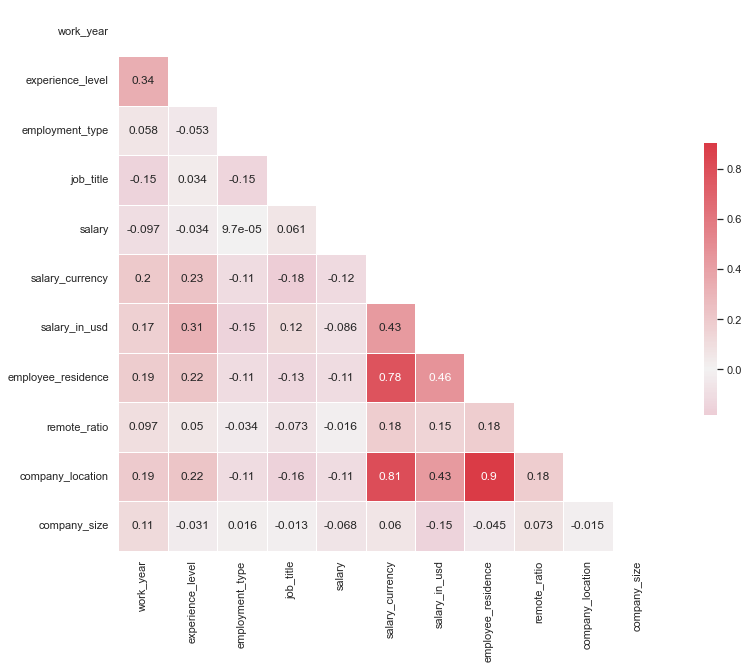

In [20]:
# buscando colinealidad

plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(sal.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(sal.corr(),
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

Debido a alta colinealidad en employee_residence y salary currency con company_location vamos a proceder a eliminar estas dos primeras columnas mencionadas.

In [21]:
sal_num = sal.drop(columns=['salary','salary_in_usd','salary_currency','company_location'])
test_num = test.drop(columns=['salary', 'salary_currency','company_location'])

Tras ver qué relaciones tienen las columnas entre si, vamos a proceder a normalizar y hacer predición con regresión lineal para conocer el peso de las diferentes variables en la explicación del salario.

In [22]:
sal_num.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_size'],
      dtype='object')

In [23]:
#columns=['work_year', 'experience_level', 'employment_type', 'job_title', 
#         'salary_currency', 'remote_ratio', 'company_size']

In [24]:
scaler=StandardScaler()

sal_num[sal_num.columns]= scaler.fit_transform(sal_num[sal_num.columns])

test_num[sal_num.columns]= scaler.fit_transform(test_num[sal_num.columns])

In [25]:
y = sal['salary_in_usd']

In [26]:
X_train, X_test, y_train, y_test = tts(sal_num, y, train_size=0.8, test_size=0.2, random_state=22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 7), (100, 7), (400,), (100,))

In [27]:
def prediction():
    errores = []
    h = [LinReg(), Lasso(), Ridge(), ElasticNet(), SVR(), RFR(), ETR(), GBR(), XGBR(), CTR()]
    modelos=['linreg', 'lasso', 'ridge', 'elastic', 'svr', 'rfr', 'etr', 'gbr', 'xgbr', 'ctr']
    for i, m in enumerate (modelos):
        m = h[i]
        m.fit(X_train, y_train)
        m.predict(X_test)
        y_pred = m.predict(X_test)
        errores.append(f'{m}: {mse(y_test, y_pred, squared=False)}')
    return errores

In [28]:
prediction()

Learning rate set to 0.035425
0:	learn: 71432.1537312	total: 57.7ms	remaining: 57.7s
1:	learn: 70490.3919529	total: 58.2ms	remaining: 29.1s
2:	learn: 69658.0993132	total: 58.6ms	remaining: 19.5s
3:	learn: 68801.6712940	total: 58.9ms	remaining: 14.7s
4:	learn: 67992.4543797	total: 59.4ms	remaining: 11.8s
5:	learn: 67266.9317065	total: 59.9ms	remaining: 9.92s
6:	learn: 66668.8290573	total: 60.1ms	remaining: 8.53s
7:	learn: 65998.7215998	total: 60.3ms	remaining: 7.47s
8:	learn: 65455.0466646	total: 60.5ms	remaining: 6.67s
9:	learn: 64755.6820912	total: 60.9ms	remaining: 6.03s
10:	learn: 64116.3510640	total: 61.2ms	remaining: 5.5s
11:	learn: 63501.6629427	total: 61.8ms	remaining: 5.09s
12:	learn: 62826.0242775	total: 62.1ms	remaining: 4.71s
13:	learn: 62289.1853723	total: 62.3ms	remaining: 4.39s
14:	learn: 61786.7005129	total: 62.7ms	remaining: 4.12s
15:	learn: 61235.6090580	total: 63.1ms	remaining: 3.88s
16:	learn: 60751.8947991	total: 63.3ms	remaining: 3.66s
17:	learn: 60266.6843112	tota

330:	learn: 34138.1674283	total: 184ms	remaining: 372ms
331:	learn: 34125.0351831	total: 184ms	remaining: 371ms
332:	learn: 34106.1407149	total: 185ms	remaining: 370ms
333:	learn: 34086.4139134	total: 185ms	remaining: 369ms
334:	learn: 34049.1319209	total: 185ms	remaining: 368ms
335:	learn: 34034.3628700	total: 186ms	remaining: 367ms
336:	learn: 34013.1560268	total: 186ms	remaining: 366ms
337:	learn: 33995.3704536	total: 186ms	remaining: 365ms
338:	learn: 33959.3629230	total: 187ms	remaining: 364ms
339:	learn: 33923.6686129	total: 187ms	remaining: 363ms
340:	learn: 33921.3942229	total: 187ms	remaining: 362ms
341:	learn: 33913.6472005	total: 187ms	remaining: 361ms
342:	learn: 33894.2539160	total: 188ms	remaining: 360ms
343:	learn: 33875.1723577	total: 188ms	remaining: 359ms
344:	learn: 33863.7614413	total: 188ms	remaining: 358ms
345:	learn: 33807.1172514	total: 189ms	remaining: 357ms
346:	learn: 33756.7930792	total: 189ms	remaining: 356ms
347:	learn: 33743.3452888	total: 189ms	remaining

848:	learn: 27296.9001309	total: 362ms	remaining: 64.4ms
849:	learn: 27289.2442149	total: 363ms	remaining: 64ms
850:	learn: 27280.5399178	total: 363ms	remaining: 63.6ms
851:	learn: 27276.7192427	total: 363ms	remaining: 63.1ms
852:	learn: 27270.2181727	total: 364ms	remaining: 62.7ms
853:	learn: 27268.7125228	total: 364ms	remaining: 62.3ms
854:	learn: 27259.9082924	total: 364ms	remaining: 61.8ms
855:	learn: 27248.3028199	total: 365ms	remaining: 61.4ms
856:	learn: 27244.7494537	total: 365ms	remaining: 60.9ms
857:	learn: 27238.9908510	total: 365ms	remaining: 60.5ms
858:	learn: 27226.6121076	total: 366ms	remaining: 60ms
859:	learn: 27222.0347570	total: 366ms	remaining: 59.6ms
860:	learn: 27215.9043589	total: 366ms	remaining: 59.1ms
861:	learn: 27211.1647232	total: 367ms	remaining: 58.7ms
862:	learn: 27192.5273251	total: 367ms	remaining: 58.3ms
863:	learn: 27180.9579419	total: 367ms	remaining: 57.8ms
864:	learn: 27176.9993692	total: 367ms	remaining: 57.4ms
865:	learn: 27176.7758789	total: 36

['LinearRegression(): 45102.4721249651',
 'Lasso(): 45102.349539287105',
 'Ridge(): 45095.423718284954',
 'ElasticNet(): 45528.3119564047',
 'SVR(): 56420.69756647055',
 'RandomForestRegressor(): 34490.444192686045',
 'ExtraTreeRegressor(): 43993.97579890598',
 'GradientBoostingRegressor(): 34468.77617353323',
 "XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n             early_stopping_rounds=None, enable_categorical=False,\n             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,\n             grow_policy='depthwise', importance_type=None,\n             interaction_constraints='', learning_rate=0.300000012, max_bin=256,\n             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,\n             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,\n             monotone_constraints='()', n_estimators=100, n_jobs=0,\n             num_parallel_tree=1, predictor='a

In [29]:
# entrenar 100
# hacer todos los cambios en testeo
# y predecir con muestra
# guardar predicción en columna
# eliminar el resto de columnas de muestra para que quede id y prección y subir a kaggle

Ahora hacemos la predicción con la bbdd de testeo:

In [30]:
X_train = sal_num
y_train = sal.salary_in_usd

In [31]:
X_test = test_num

In [32]:
#gbr=GBR()
#gbr.fit(X_train, y_train)
#test_num['salary_in_usd'] = gbr.predict(X_test)

In [33]:
rfr=RFR()
rfr.fit(X_train, y_train)
test_num['salary_in_usd'] = rfr.predict(X_test)

In [34]:
test_num = test_num.reset_index()

In [35]:
test_num.columns

Index(['index', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'employee_residence', 'remote_ratio', 'company_size',
       'salary_in_usd'],
      dtype='object')

In [36]:
test_final = test_num.drop(columns= ['work_year', 'experience_level', 'employment_type', 'job_title', 'remote_ratio',
       'employee_residence', 'company_size'])

In [37]:
test_final.head()

,index,salary_in_usd
0,0,132547.3400
1,1,319074.0000
2,2,94618.0000
3,3,96304.8300
4,4,49283.3975


In [38]:
test_final.columns = ['id','salary_in_usd']

In [39]:
test_final.head()

,id,salary_in_usd
0,0,132547.3400
1,1,319074.0000
2,2,94618.0000
3,3,96304.8300
4,4,49283.3975


In [40]:
test_final.to_csv('data/prediccion2.csv', index=False)